4002/4002 [==============================] - 74s 18ms/step - loss: 6.5266e-04


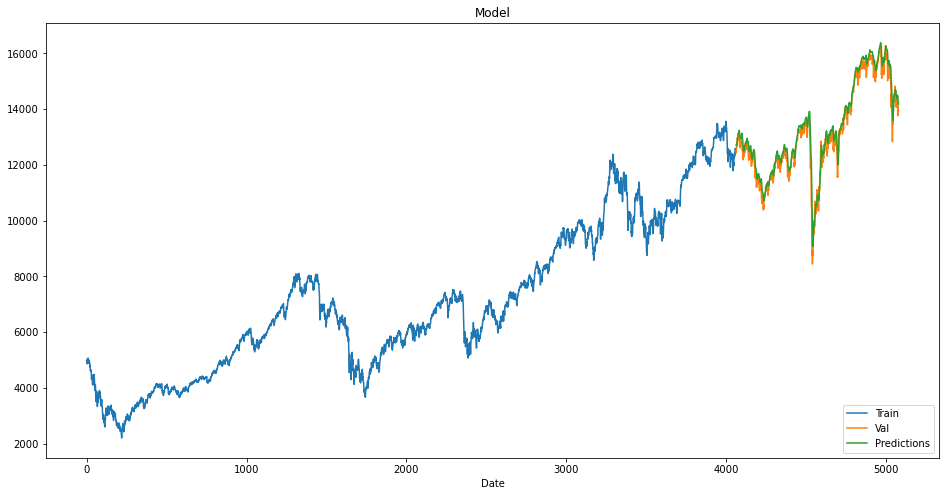

In [6]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.express as px
import os
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv
from selenium import webdriver
#from selenium.webdriver.chrome.options import Options
from selenium.webdriver.firefox.options import Options
import random
import warnings
warnings.filterwarnings("ignore")

os.chdir('C:/Users/Sven Konermann/Documents/GitHub/DataScience/Data')

ua_path = "user_agents.txt"
ua_list = [line.rstrip('\n') for line in open(ua_path)]
ua_list[:5]

# List with URLS for Webscraping part 1
url_1_raw = "URL_1.txt"
url_1 = [line.rstrip('\n') for line in open(url_1_raw)]
url_1[:5]

# List with URLS for Webscraping part 2
url_2_raw = "URL_2.txt"
url_2 = [line.rstrip('\n') for line in open(url_2_raw)]
url_2[:5]

opts = Options()
opts.add_argument("--headless")
#opts.add_argument("--window-size=1200,800")
opts.add_argument("user-agent=" + random.choice(ua_list))
#driver = webdriver.Chrome(executable_path='chromedriver.exe', options=opts)
driver = webdriver.Chrome(executable_path='geckodriver.exe', options=opts)

#Websites to Scrape
IndexListe= ["DAX", "EURO STOXX 50", "Dow Jones",  "SMI", "MSCI World", "FTSE", "ATX", "SDAX", "Tec DAX", "NASDAQ 100", "Nikkei", "Hang Seng", "SHANGHAI STOCK EXCHANGE B SHARES", "Emerging Markets", "Bovespa"]

#Scraping Loop
x=0
while x < len(url_1):
    Text=""
    Jahr=2002
    while Jahr <=2017:
        URL = str(url_1[x])+str(Jahr)+str(url_2[x])
        driver.get(URL)
        text1 = driver.find_element_by_css_selector('body > div.INHALT.WEBSEITE > article > table > tbody').text
        Text= Text + '\n' + text1
        templist = []
        Table_dict={ 'Gescrapte Finanzdaten': Text}
        templist.append(Table_dict)
        df = pd.DataFrame(templist)
        Jahr+=5
    df.to_csv(IndexListe[x]+"_Test.csv")
    df = pd.read_csv(IndexListe[x]+"_Test.csv", delimiter=' ', header=None, skiprows=2, names=['Datum','Eröffnung','Hoch','Tief','Schluss','Volumen'], index_col=False)
    for i in range (len(df)):
        df.loc[i,'Eröffnung'] = df.loc[i,'Eröffnung'].replace('.','')
        df.loc[i,'Eröffnung'] = df.loc[i,'Eröffnung'].replace(',','.')
        df.loc[i,'Hoch'] = df.loc[i,'Hoch'].replace('.','')
        df.loc[i,'Hoch'] = df.loc[i,'Hoch'].replace(',','.')
        df.loc[i,'Tief'] = df.loc[i,'Tief'].replace('.','')
        df.loc[i,'Tief'] = df.loc[i,'Tief'].replace(',','.')
        df.loc[i,'Schluss'] = df.loc[i,'Schluss'].replace('.','')
        df.loc[i,'Schluss'] = df.loc[i,'Schluss'].replace(',','.')
        df.loc[i,'Volumen'] = df.loc[i,'Volumen'].replace('.','')
        df.loc[i,'Volumen'] = df.loc[i,'Volumen'].replace(',','.')
        i+=1

    df['Datum'] = pd.to_datetime(df.Datum, format="%d.%m.%Y")
    df['Eröffnung'] = df['Eröffnung'].astype(float)
    df['Hoch'] = df['Hoch'].astype(float)
    df['Tief'] = df['Tief'].astype(float)
    df['Schluss'] = df['Schluss'].astype(float)
    
#Data Normalization

    data = df.filter(['Schluss'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset) * .8)
    training_data_len
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len ,:]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
#Model

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
    
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.plot(train['Schluss'])
    plt.plot(valid[['Schluss', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show
    
    plt.savefig(IndexListe[x]+'.png')
    
    valid.to_csv(IndexListe[x]+'_valid.csv')
    
    score=(sum(abs(valid['Schluss']-valid['Predictions'])/valid['Schluss'])/len(valid['Schluss']))*100
    score1=[]
    score1.append(score)
        
    acc_score=(1-sum(abs(valid['Schluss']-valid['Predictions'])/valid['Schluss'])/len(valid['Schluss']))*100
    acc_score1=[]
    acc_score1.append(acc_score)
    x+=100

with open('score.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(score1)  
        
with open('accscore.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(acc_score1) 